In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

from pytorchtools_Transformer_simple import EarlyStopping

from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR

import scipy.stats as st

from matplotlib.offsetbox import AnchoredText
import math

In [4]:
#GPU
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print(f"Using {device} device")

Using cuda:0 device


In [5]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout = 0.1, max_len = 512):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [6]:
class Transformer(nn.Module):
    def __init__(self, d_model, num_layers, p, neg_slope, n_head, pos_dropout):
        super(Transformer, self).__init__()

        self.dmodel = d_model
        self.encoder_layer = nn.TransformerEncoderLayer(d_model = d_model, nhead = n_head, dim_feedforward = 2048, dropout = 0.25, batch_first = False, dtype = torch.float)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer = self.encoder_layer, num_layers = num_layers)
        self.pos_encoder = PositionalEncoding(d_model = d_model, dropout = pos_dropout)
        
        self.linear = nn.Linear(3, d_model)
        
        self.fcff = nn.Sequential(
          
            nn.Linear(512, 1200),
            nn.BatchNorm1d(1200),
            nn.Dropout1d(p = p),
            nn.LeakyReLU(neg_slope),
            
            nn.Linear(1200, 450),
            nn.BatchNorm1d(450),
            nn.Dropout1d(p = p),
            nn.LeakyReLU(neg_slope),

            nn.Linear(450, 30),
            nn.BatchNorm1d(30),
            nn.Dropout1d(p = p),
            nn.LeakyReLU(neg_slope),

            nn.Linear(30, 5),
        )
        
        self.apply(self._init_weights)
    
    def _init_weights(self,module):
        
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, 0, 0.1)
            if module.bias is not None:
                module.bias.data.fill_(0.08)
        
    
    def forward(self, x1, x2):

        x1 = x1.permute(1, 0, 2)
        x1 = self.linear(x1)
        x1 = self.pos_encoder(x1 * torch.sqrt(torch.tensor(self.dmodel)))
        x1 = self.transformer_encoder(x1)
        x1 = x1.permute(1, 0, 2)
        x1 = torch.flatten(x1, 1)
        x1 = self.fcff(x1)

        x2 = x2.permute(1, 0, 2)
        x2 = self.linear(x2)
        x2 = self.pos_encoder(x2 * torch.sqrt(torch.tensor(self.dmodel)))
        x2 = self.transformer_encoder(x2)
        x2 = x2.permute(1, 0, 2)
        x2 = torch.flatten(x2, 1)
        x2 = self.fcff(x2)
        
        return torch.stack([x1, x2])

In [7]:
class MyLoss (nn.Sequential):
    def __init__(self):
        super(MyLoss, self).__init__()

    def forward(self, W, E):
        
        xw, yw = torch.nonzero(W, as_tuple = True)
        
        W = W[xw,yw]
        E = E[xw,yw]

        loss = torch.mean(torch.abs(E-W)/W)

        return loss

In [8]:
def Reg_Loss(loss, LAMBDA):
    
    l_reg = 0
    for W in model.parameters():
        l_reg = l_reg + torch.norm(W, 1)
    
    loss_reg = loss + LAMBDA*l_reg
    
    return loss_reg

In [9]:
def Dist(W, E):
    
    x, y = torch.nonzero(W, as_tuple = True)
    
    W = W[x,y]
    E = E[x,y]
    
    dist = E/W
    
    return dist

In [10]:
def Train(train, W_dist_train, LAMBDA):
    # train_losses = []
    
    for batch_x in range (n_batches_train):
        for batch_y in range (n_batches_train):
            if torch.count_nonzero(W_dist_train[batch_x][batch_y]) != 0:
                
                sample_emb_train = model(train[batch_x], train[batch_y])
                E_dist_train = torch.cdist(sample_emb_train[0], sample_emb_train[1], p = 2)

                loss = criterion(W_dist_train[batch_x][batch_y], E_dist_train)
                # dist = Dist(W_dist_train[batch_x][batch_y], E_dist_train)
                loss_reg = Reg_Loss(loss, LAMBDA)
                # train_losses.append(loss_reg.item())
                with model.join():

                    optimizer.zero_grad()
                    loss_reg.requires_grad_()
                    loss_reg.backward(retain_graph=True)

                    optimizer.step()
    # return train_losses

In [11]:
def Validation(validaiton, W_dist_validation):
    
    sample_emb_validation = model(validation, validation)
    E_dist_validation = torch.cdist(sample_emb_validation[0], sample_emb_validation[0], p = 2)
    valid_loss = criterion(W_dist_validation, E_dist_validation)
    
    return valid_loss


In [12]:
def Test(test, W_dist_test):
    
    sample_emb_test = model(test, test)
    E_dist_test = torch.cdist(sample_emb_test[0], sample_emb_test[1], p = 2)
    test_loss = criterion(W_dist_test, E_dist_test)
    test_dist = Dist(W_dist_test, E_dist_test)

    median_test = torch.median(test_dist)
    
    fig3, ax3_test = plt.subplots(1,1, figsize=(7,7))

    ax3_test.set_title('Test set', fontsize = 30)
    ax3_test.set_xlim([-0.1,1.5])
    ax3_test.set_xlabel("Distortion", fontsize = 20)
    ax3_test.set_ylabel("Density", fontsize = 20)
    ax3_test.tick_params(axis='both', which='major', labelsize=15)
    labels = ['Ideal']

    count_test, bins_test, p_test = ax3_test.hist(test_dist.cpu().detach().numpy(), color = 'b', bins = 'auto', density = True, edgecolor = 'b')
    ax3_test.axvline(x=1, color='r', linestyle='dashed')

    mode_index_test = count_test.argmax()
    mode_test = (bins_test[mode_index_test] + bins_test[mode_index_test+1])/2
    var_mode_test = np.sqrt(np.average((1-mode_test)*(1-mode_test)))

    ax3_test.legend(labels, fontsize = 12, loc = 'upper right', edgecolor = 'black',  bbox_to_anchor=(1, 1), bbox_transform=ax3_test.transAxes)
    anchored_text_test = AnchoredText('Median:'+str('%.2f' % median_test.item()), loc='upper right', bbox_to_anchor = (0.99,0.93), bbox_transform=ax3_test.transAxes)
    ax3_test.add_artist(anchored_text_test)
    
    # fig3.savefig('/home/gbortolai/Thesis/Plot/Jets/Simple/Transformer.pdf', facecolor='w',pad_inches=0.3, transparent=True)
    
    # return test_dist


In [20]:
#Dataloder
# device = 'cuda:1'
train, _ = torch.load('/home/gbortolai/Thesis/data/Jets/dataset_train')
validation, _  = torch.load('/home/gbortolai/Thesis/data/Jets/dataset_validation')

train = train.to(device)
validation = validation.to(device)

W_dist_train, _ = torch.load('/home/gbortolai/Thesis/data/Jets/Wasserstein_dist_train_s=12000')
W_dist_validation, _ = torch.load('/home/gbortolai/Thesis/data/Jets/Wasserstein_dist_validation_s=2400')

W_dist_train = W_dist_train.to(device)
W_dist_validation = W_dist_validation.to(device)

train = train.to(torch.float)
validation = validation.to(torch.float)

#parameters

n_sample_train = train.size(0)
batch_size = 300
n_batches_train = int(n_sample_train/batch_size)

train = torch.stack(torch.chunk(train, n_batches_train, dim = 0), dim = 0)
W_dist_train = torch.stack(torch.chunk(torch.stack(torch.chunk(W_dist_train, n_batches_train, dim = -1), dim = 0), n_batches_train, dim = 1), dim = 0)

d_model = 32
num_layers = 2
n_head = 4
pos_dropout = 0.1

#Train
#-----------------------------------------------------------------------------------------------------------SETTING
learning_rate = 1e-2

criterion = MyLoss()
#criterion = nn.MSELoss()

LAMBDA = 1e-3
patience = 30
iteration = 1000
neg_slope = 1e-2
p = 0.1

model = Transformer(d_model, num_layers, p, neg_slope, n_head, pos_dropout)
torch.distributed.init_process_group()
model = nn.parallel.DistributedDataParallel(model, device_ids = None)
model.to(device)

optimizer = optim.Adam(model.parameters(),lr = learning_rate, weight_decay = 0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 30, gamma = 0.5)
early_stopping = EarlyStopping(patience = patience, verbose = True)

fig = plt.figure(figsize = (14, 7), constrained_layout=False)
gs = GridSpec(1, 2, figure = fig)

ax3 = fig.add_subplot(gs[0, 0])
ax3.set_title('Loss train average')
ax3.set_ylabel('Loss train average')
ax3.set_ybound(lower = 0, upper = None)

ax4 = fig.add_subplot(gs[0, 1])
ax4.set_title('Loss validation average')
ax4.set_ylabel('Loss validation average')
ax4.set_ybound(lower = 0, upper = None)

#ax5 = fig.add_subplot(gs[0, 0])
#ax5.set_title('Distortion validation')
#ax5.set_ylabel('Distortion')
#ax5.axvline(x=1, color='r', linestyle='-')
#ax5.set_xlim(-0.1, 4)
#ax5.set_ylim(-0.1, 0.5)

#fig.suptitle("MNIST and lr= "+str(learning_rate)+'p value is:'+str(p)+'la loss é:MyLoss')

for ite in range (iteration):
    #Train
    model.train()
    train_losses = Train(train, W_dist_train, LAMBDA)
    train_loss = np.average(train_losses)
    train_losses = []
    ax3.scatter(ite, train_loss, color = 'b', s = 5)

    #Validation
    model.eval()
    valid_loss = Validation(validation, W_dist_validation)
    ax4.scatter(ite, valid_loss.cpu().detach().numpy(), color = 'b', s = 5)

    early_stopping(valid_loss, model)
    scheduler.step()


    if early_stopping.early_stop:
            print("Early stopping")
            break

ValueError: Error initializing torch.distributed using env:// rendezvous: environment variable RANK expected, but not set

In [56]:
# dist = []

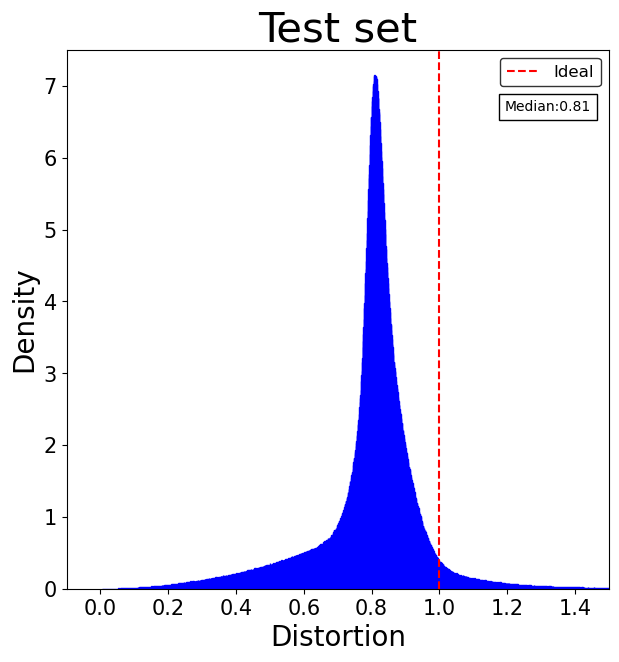

In [155]:
device = 'cpu'
test, _ = torch.load('/home/gbortolai/Thesis/data/Jets/dataset_test', map_location = device)
W_dist_test, target_test = torch.load('/home/gbortolai/Thesis/data/Jets/Wasserstein_dist_test_s=4000', map_location = device)

test = test.to(torch.float)

criterion = MyLoss()

neg_slope = 1e-2
p = 0.1
d_model = 32
num_layers = 2
n_head = 4
pos_dropout = 0.1

model = Transformer(d_model, num_layers, p, neg_slope, n_head, pos_dropout).to(device)
model.load_state_dict(torch.load('/home/gbortolai/Thesis/Checkpoint/checkpoint_transformer_simple.pth', map_location = device))

model.eval()
Test(test, W_dist_test)
# dist.append(Test(test, W_dist_test))

In [86]:
print(len(dist))
# torch.save(dist, '/home/gbortolai/Thesis/data/Jets/dist_multi_2-7')

6


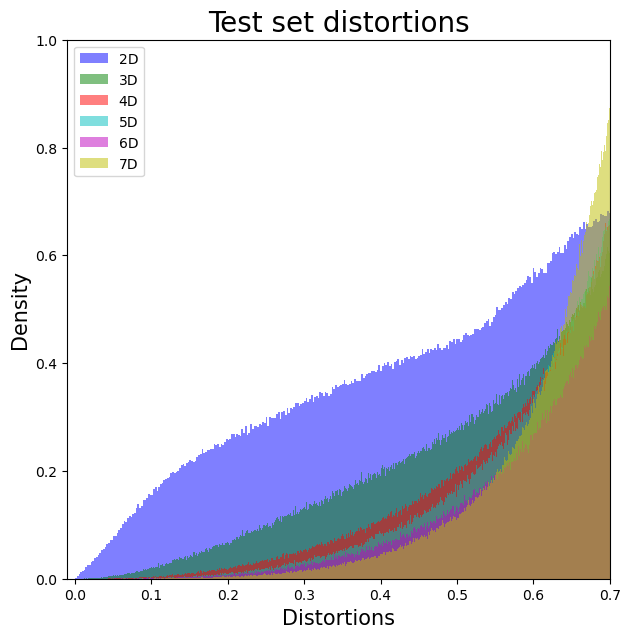

In [100]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
ax.set_xlim([-0.01, 0.7])
ax.set_ylim([0,1])
ax.set_title('Test set distortions', fontsize = 20)
ax.set_xlabel('Distortions', fontsize = 15)
ax.set_ylabel('Density', fontsize = 15)

colors = ['b', 'g', 'r','c','m','y','k']
for i in [2,3,4,5,6,7]:
    ax.hist(dist[i-2].detach().numpy(), bins = 'auto', density = True, alpha = 0.5, color = colors[i-2], label = str(i)+'D')
ax.legend(loc = 'best')
fig.savefig('/home/gbortolai/Thesis/Plot/Jets/Simple/Distortions_tails.pdf', facecolor='w',pad_inches=0.3, transparent=True)

def Test(test, W_dist_test):
    criterion = MyLoss()
    #criterion = nn.MSELoss()

    neg_slope = 1e-2

    p = 0.1

    d_model = 32
    num_layers = 2
    n_head = 4
    pos_dropout = 0.1


    model = Transformer(d_model, num_layers, p, neg_slope, n_head, pos_dropout).to(device)


    #test 
    model.load_state_dict(torch.load('/home/gbortolai/Thesis/Checkpoint/checkpoint_transformer_simple_old.pth', map_location = device))
    #-----------------------------------------------------------------------------------SETTING
    model.eval()
    #--------------------------------------------------------------------------------------EMBEDDING

    sample_emb_test = model(test, test).to(device)

    E_dist_test = torch.cdist(sample_emb_test[0], sample_emb_test[1], p = 2).to(device)

    test_loss = criterion(W_dist_test, E_dist_test)
    test_dist = Dist(W_dist_test, E_dist_test)
    # test_loss_reg = Reg_Loss(test_loss, LAMBDA)

    # test_dist_mean = torch.mean(test_dist)
    # var_test = np.sqrt(torch.mean((1-test_dist_mean)*(1-test_dist_mean)).cpu().detach().numpy())

    # median_test = torch.median(test_dist)

    # print('Dist mean:', test_dist_mean.item(),u"\u00B1", var_test.item())
    print(test_loss)
#     fig3, ax3_test = plt.subplots(1,1, figsize=(7,7))

#     ax3_test.set_title(f'Test set{prongx}-{prongy}', fontsize = 30)

#     # ax3_test.set_xlim([-0.1,1.5])
#     ax3_test.set_xlabel("Distortion", fontsize = 20)
#     ax3_test.set_ylabel("Density", fontsize = 20)
#     ax3_test.tick_params(axis='both', which='major', labelsize=15)
#     labels = ['Ideal']#, 'mode', 'mean','median']
#     #plt.axhline(y=1, color='r', linestyle='-')
#     #for i in range(targets_test.size(0)):
#         #if targets_test[i] == 2:
#     count_test, bins_test, p_test = ax3_test.hist(test_dist.cpu().detach().numpy(), color = 'b', bins = 'auto', density = True, edgecolor = 'b')
#     ax3_test.axvline(x=1, color='r', linestyle='dashed')

#     mode_index_test = count_test.argmax()
#     mode_test = (bins_test[mode_index_test] + bins_test[mode_index_test+1])/2
#     var_mode_test = np.sqrt(np.average((1-mode_test)*(1-mode_test)))

#     # ax3_test.axvline(x=mode_test, color='green', linestyle='-')
#     # ax3_test.axvline(x=test_dist_mean.cpu().detach().numpy(), color='yellow', linestyle='-')
#     # ax3_test.axvline(x=median_test.cpu().detach().numpy(), color='purple', linestyle='-')
#     #plt.axvline(x=test_loss.detach().numpy(), color='orange', linestyle='-')
#     ax3_test.legend(labels, fontsize = 12, loc = 'upper right', edgecolor = 'black',  bbox_to_anchor=(1, 1), bbox_transform=ax3_test.transAxes)

#     # anchored_text_test = AnchoredText('Mode:'+str('%.3f' % mode_test.item())+u"\u00B1"+str('%.3f' % var_mode_test.item())+'\nDist:'+str('%.3f' % test_dist_mean.item())+u"\u00B1"+str('%.3f' % var_test.item()+'\nMedian:'+str('%.3f' % median_test.item())), loc='lower right')
#     anchored_text_test = AnchoredText('Median:'+str('%.2f' % median_test.item()), loc='upper right', bbox_to_anchor = (0.99,0.93), bbox_transform=ax3_test.transAxes)
#     # ax3_test.text(0.8, 0.83,'Mode:'+str('%.2f' % mode_test.item())+'\nDist:'+str('%.2f' % test_dist_mean.item())+'\nMedian:'+str('%.2f' % median_test.item()), transform=ax3_test.transAxes, bbox=dict(facecolor='white'))
#     ax3_test.add_artist(anchored_text_test)
#     # fig3.savefig(f'/home/gbortolai/Thesis/Plot/Jets/Simple/Transformer{prongx}-{prongy}.pdf', facecolor='w',pad_inches=0.3, transparent=True)
    return test_dist

AttributeError: 'list' object has no attribute 'detach'

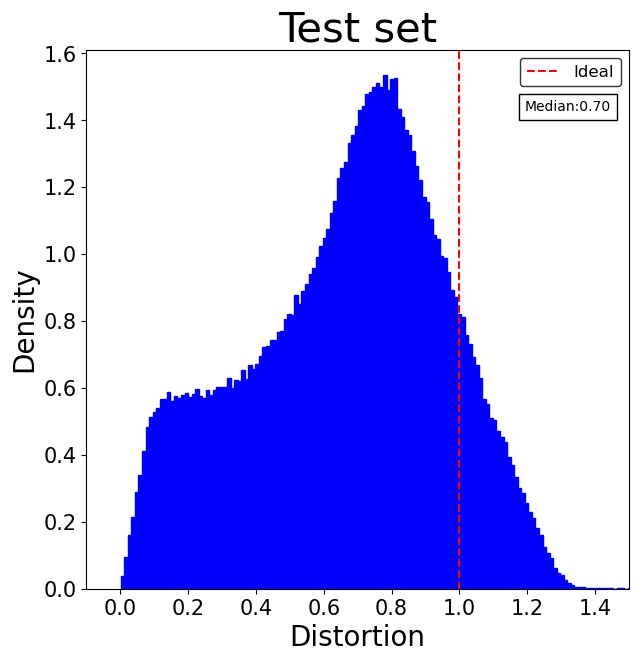

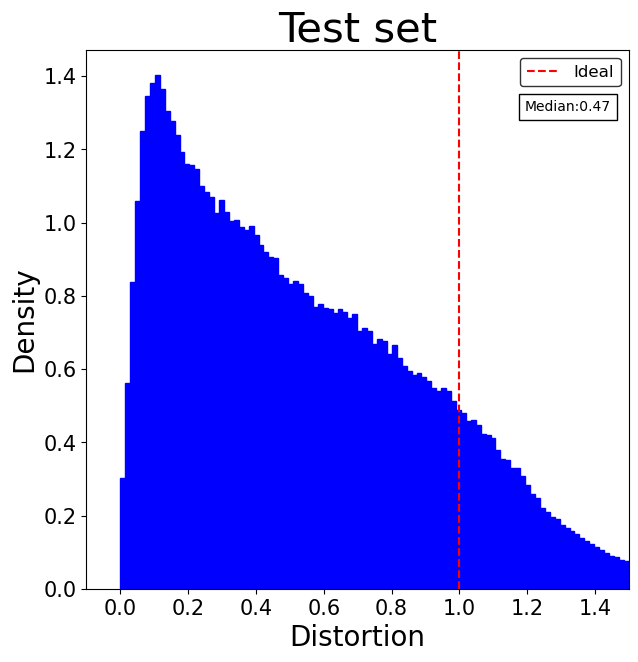

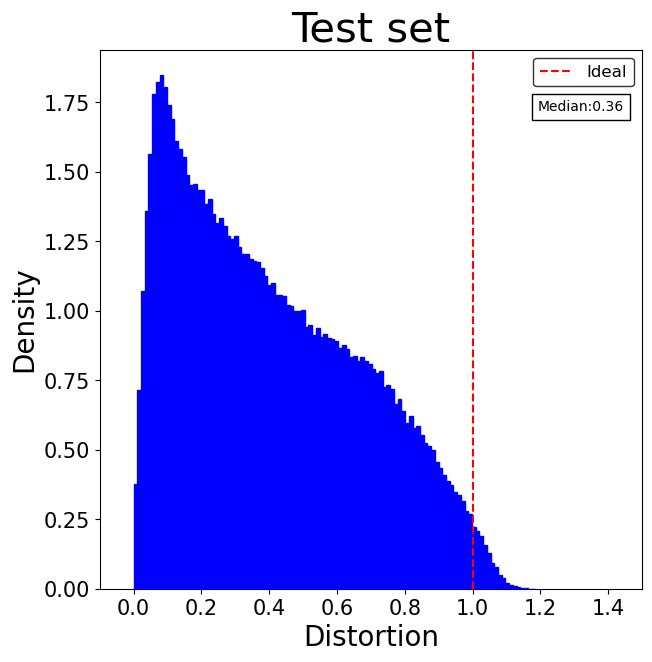

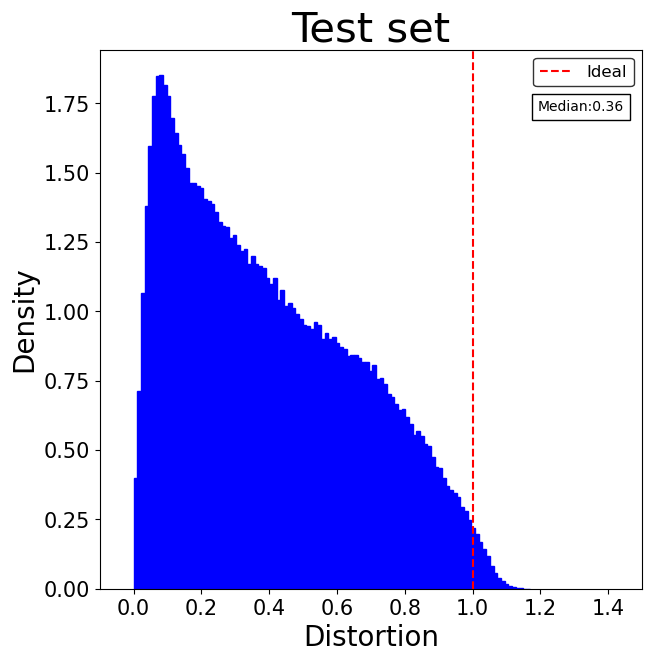

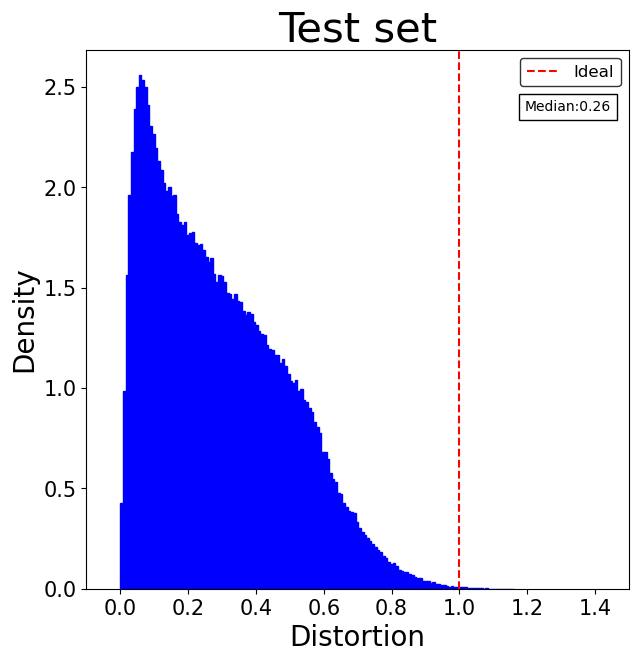

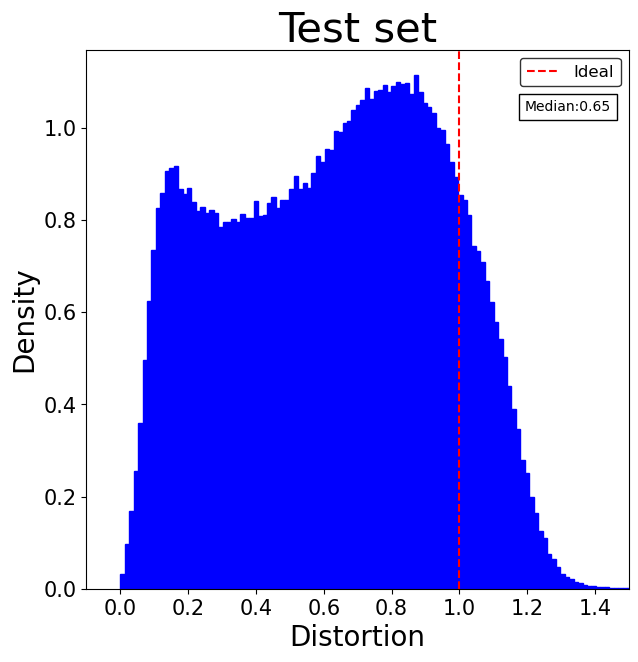

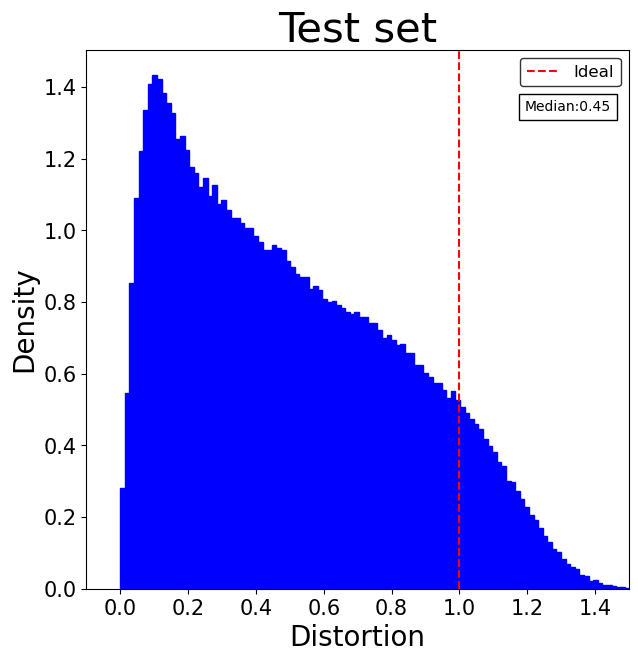

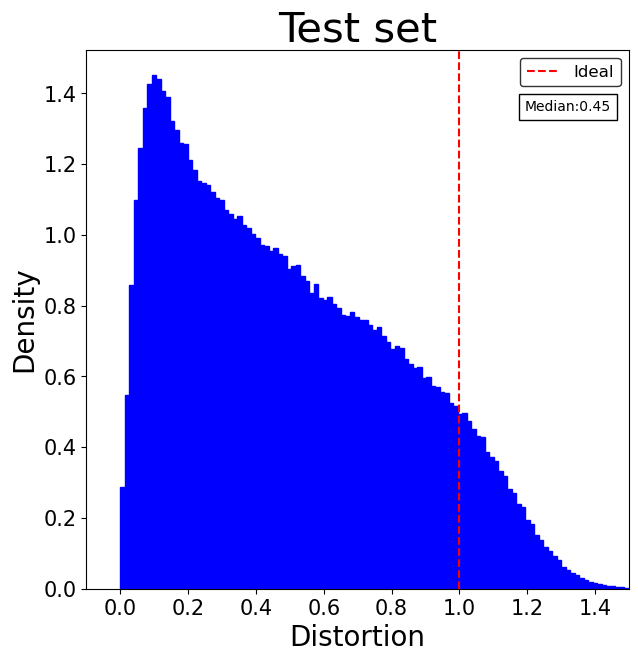

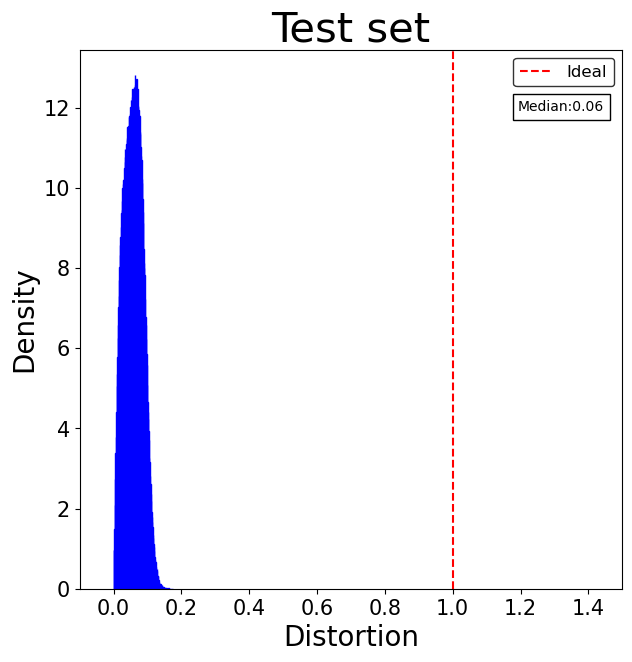

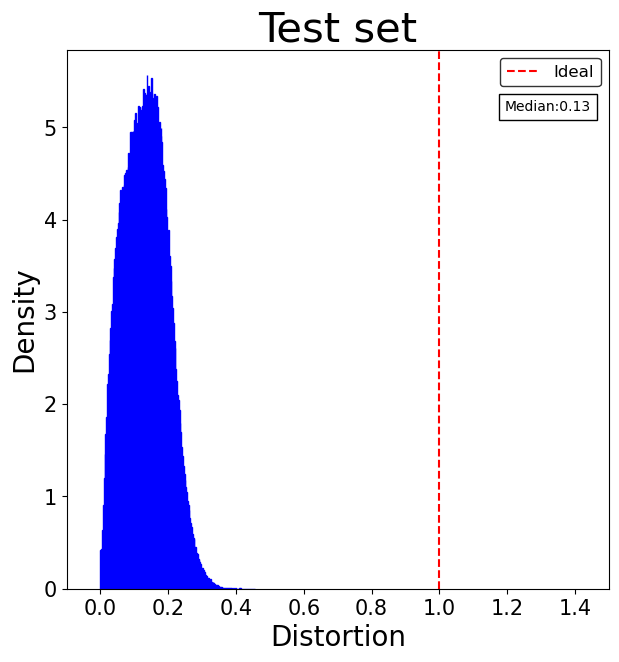

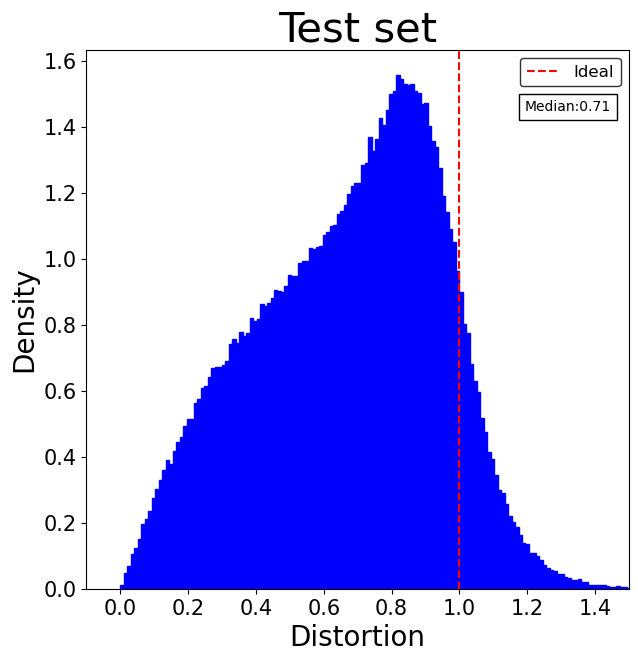

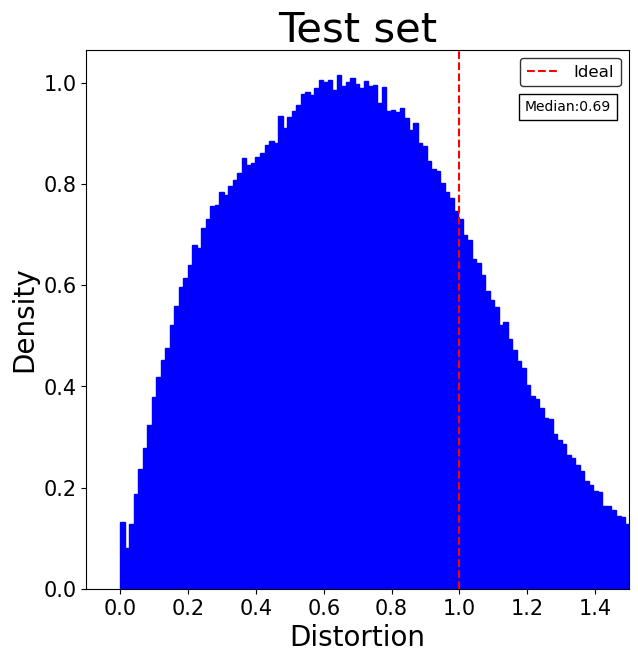

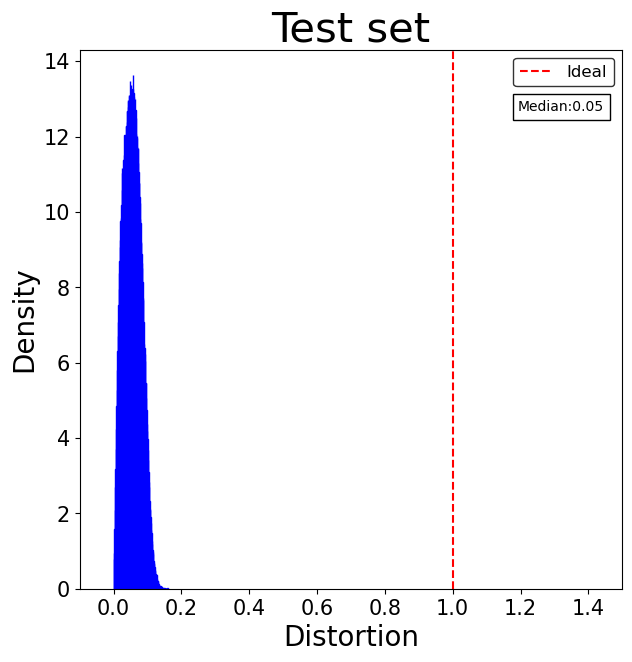

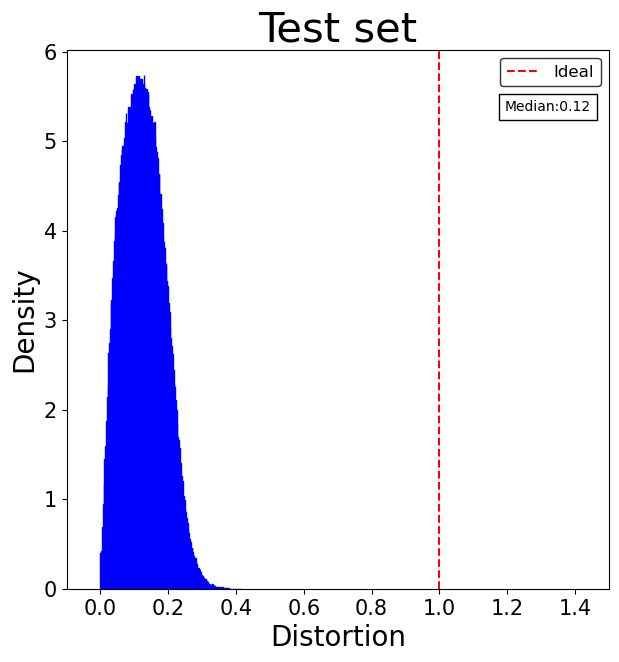

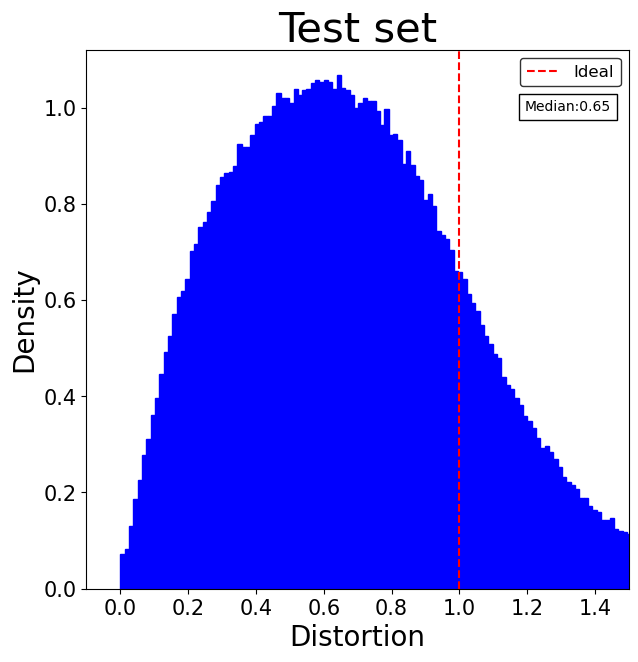

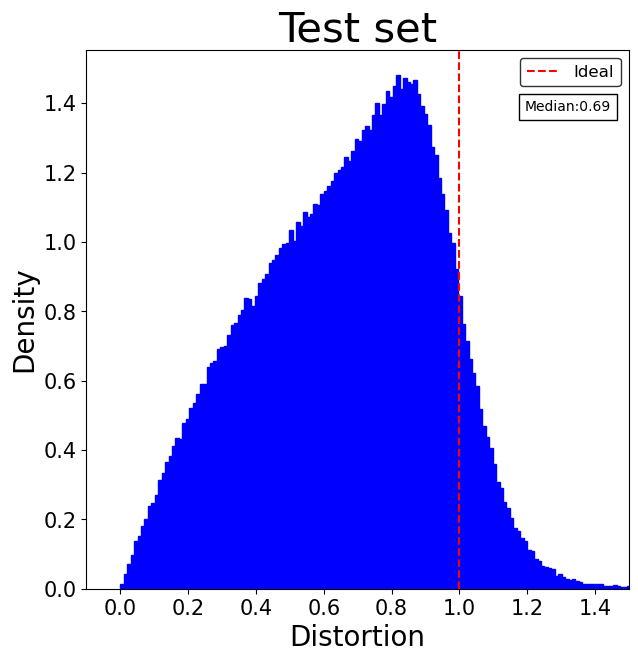

In [136]:
test, _ = torch.load('/home/gbortolai/Thesis/data/Jets/dataset_test', map_location=device)
W_dist_test, target_test = torch.load('/home/gbortolai/Thesis/data/Jets/Wasserstein_dist_test_s=4000', map_location=device)

test = test.to(torch.float)

subdata = torch.zeros(torch.count_nonzero(target_test == 1).item(), 16, 3)
subW = torch.zeros(torch.count_nonzero(target_test == 1).item(), torch.count_nonzero(target_test == 1).item())


dist = []
for prongx in [1,2,3,4]:
    for prongy in [1,2,3,4]:
        l = 0
        for i in torch.nonzero(target_test == prongx)[:,0]:
            subdata[l] = test[i]
            m = 0
            for j in torch.nonzero(target_test == prongy)[:,0]:
                subW[l][m] = W_dist_test[i][j]
                m = m+1
            l = l+1
        dist.append(Test(subdata, subW))



plt.hist(dist.detach().numpy(), bins = 'auto')

(array([4.40646370e-01, 8.92290570e-01, 1.37740996e+00, 1.75988330e+00,
        2.05632196e+00, 2.25570668e+00, 2.44985575e+00, 2.59184298e+00,
        2.71296575e+00, 2.80490761e+00, 2.84125105e+00, 2.81527700e+00,
        2.76477077e+00, 2.62506690e+00, 2.44895498e+00, 2.24087603e+00,
        2.01943209e+00, 1.83869061e+00, 1.69592829e+00, 1.59311429e+00,
        1.53056282e+00, 1.50816726e+00, 1.47919956e+00, 1.46482539e+00,
        1.44084327e+00, 1.43516271e+00, 1.41618715e+00, 1.40198072e+00,
        1.36509431e+00, 1.33928269e+00, 1.29966960e+00, 1.27459776e+00,
        1.22632988e+00, 1.19715199e+00, 1.14557448e+00, 1.09630700e+00,
        1.06018953e+00, 1.01703873e+00, 9.77737325e-01, 9.36073648e-01,
        9.07099919e-01, 8.75218910e-01, 8.58397446e-01, 8.34847417e-01,
        8.12604518e-01, 8.06403828e-01, 7.88949976e-01, 7.72195296e-01,
        7.66811589e-01, 7.63417969e-01, 7.61319340e-01, 7.48020987e-01,
        7.39097022e-01, 7.36834609e-01, 7.34652320e-01, 7.298378

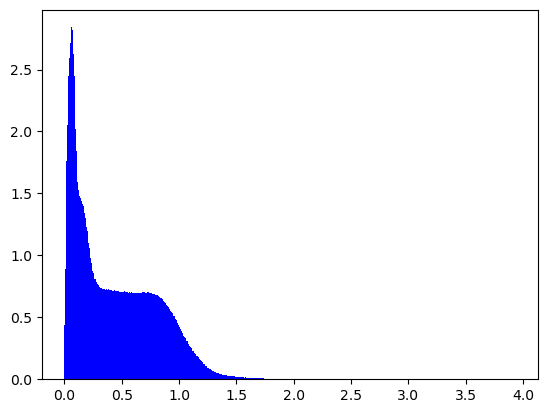

In [138]:
plt.hist(torch.cat(dist).detach().numpy(), bins = 'auto', color = 'b', density = True)

# dist = torch.cat(torch.chunk(torch.cat(dist, dim = -1), 4000, dim = -1), dim = 0)
# print(torch.cat(dist, dim = 0).size())
# a = plt.hist(subW.detach().numpy(), color = 'b', density = True, bins = 'auto')
print(subW.size())
v = []
for i in range(1000):
        for j in filter(lambda h: h>i, range(1000)):
            v.append(subW[i][j].item())
plt.hist(v, bins = 'auto', linewidth = 0.8, alpha = 0.5, density = True, color = 'b')

In [13]:
fig3.savefig('/home/gbortolai/Thesis/Plot/Jets/Simple/Transformer_3D.pdf', facecolor='w',pad_inches=0.3, transparent=True)

NameError: name 'fig3' is not defined

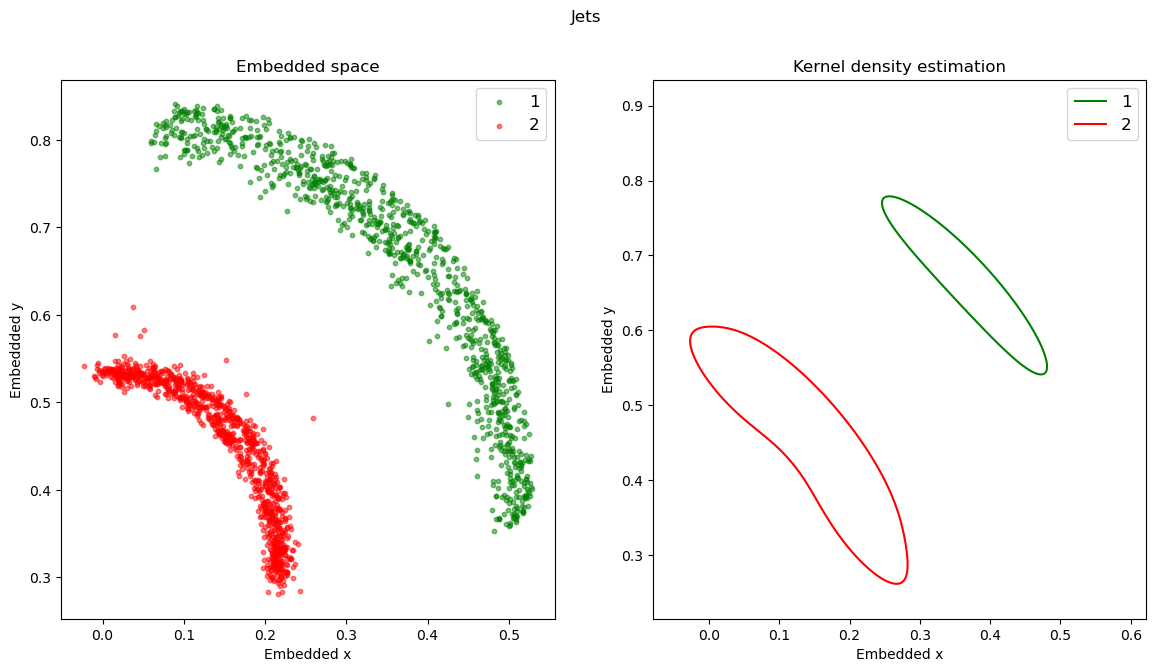

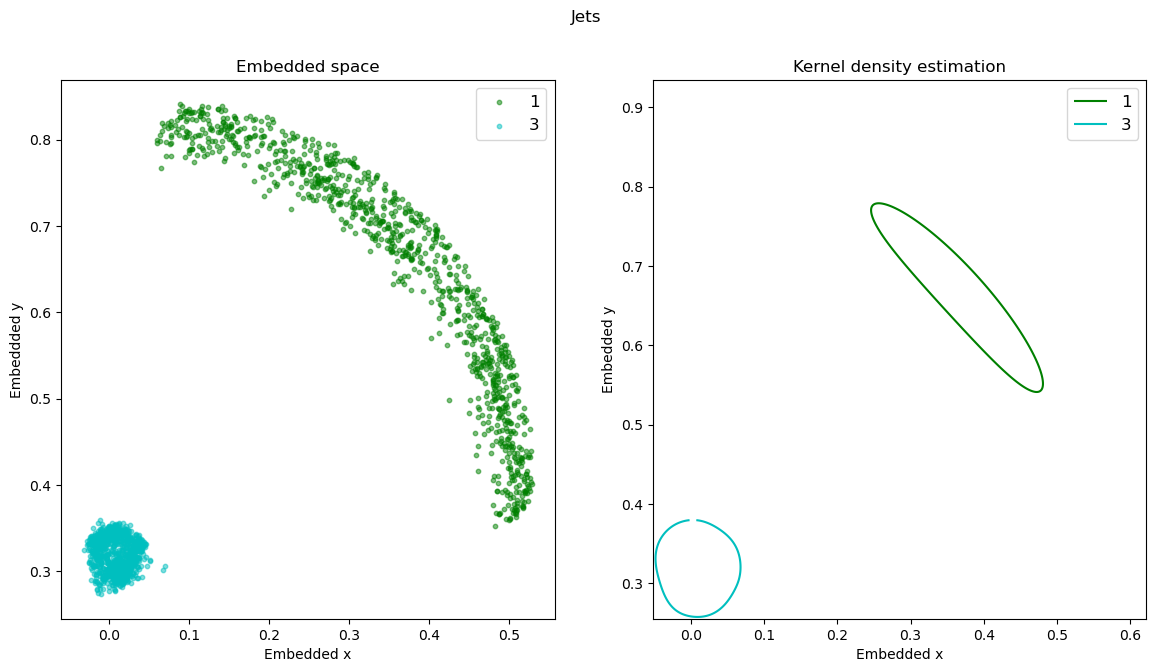

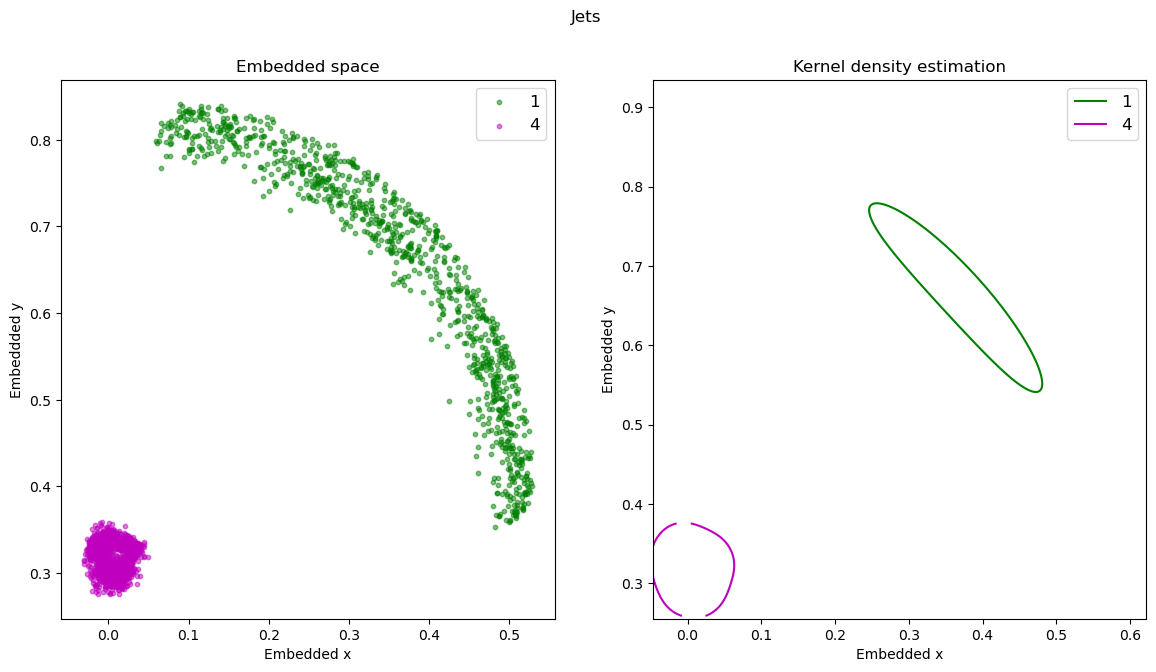

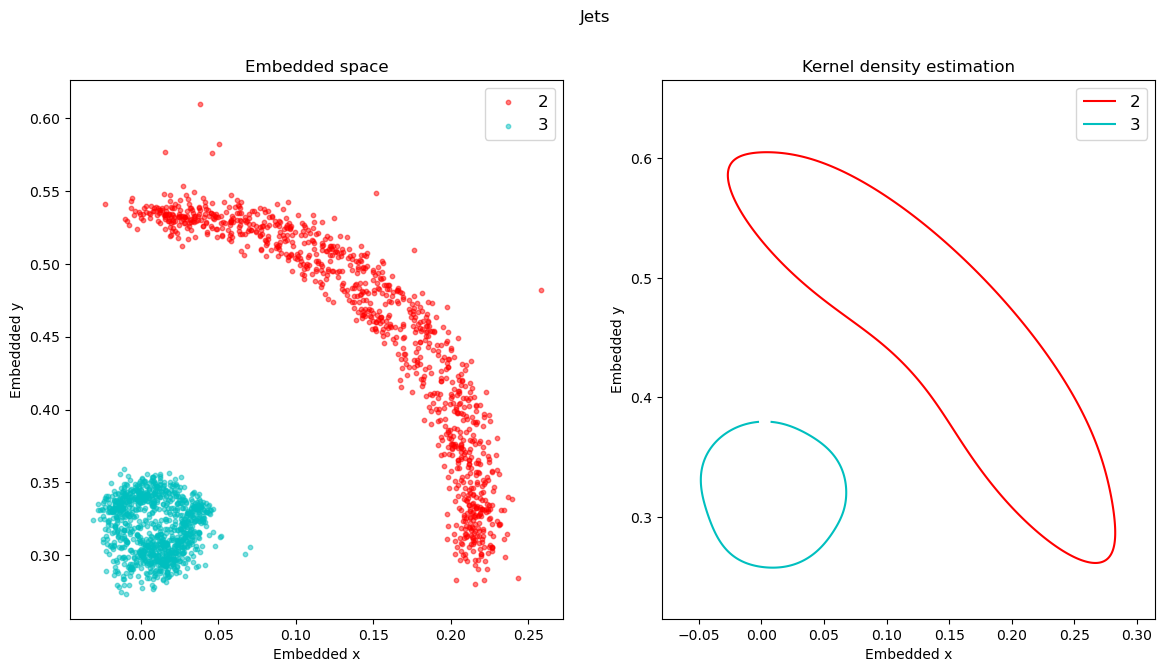

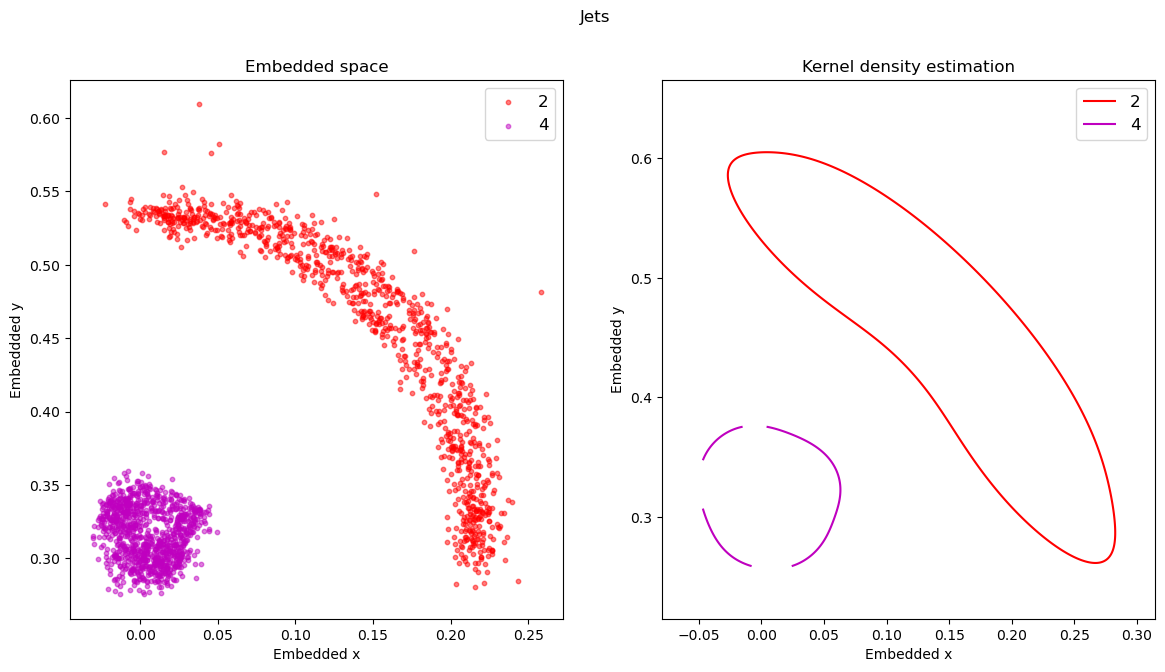

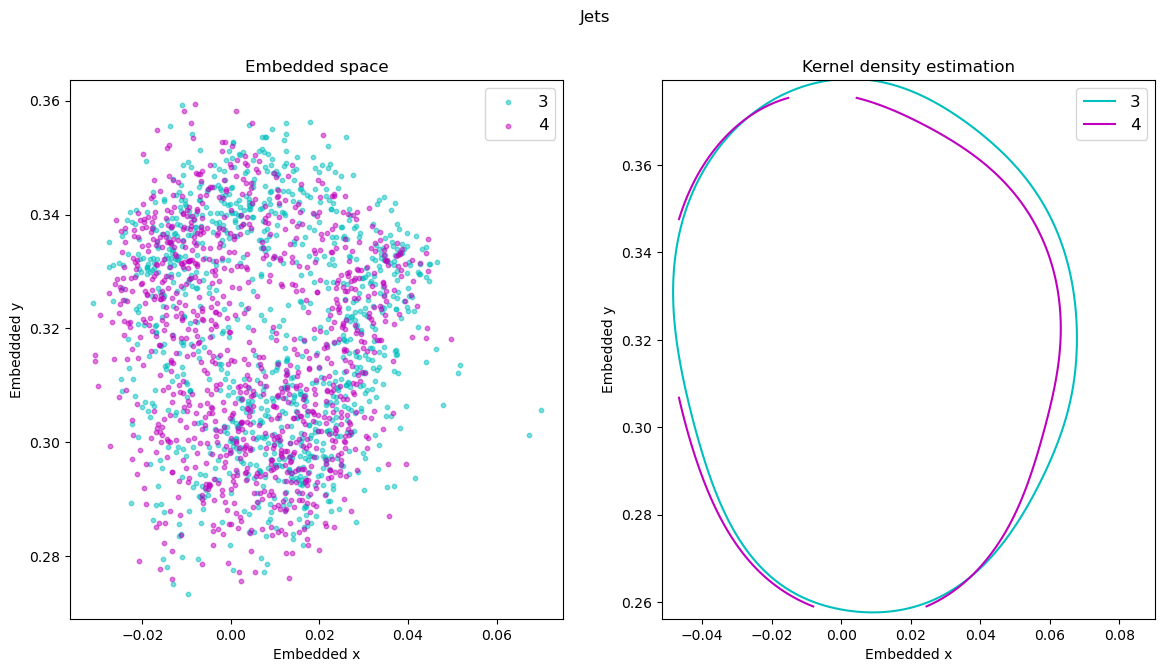

In [37]:
#------------------------------------------------------------------------------------PLOT
labels = ['1','2','3','4']

colors = ['g', 'r','c','m']

var, col = [], []

n_bullet = 0
n_target = 0

for n_bullet in [1,2,3,4]:
    for n_target in [1,2,3,4]:
        if n_target > n_bullet:
            fig_test = plt.figure(figsize=(14, 7), constrained_layout=False)
            gs_test = GridSpec(1, 2, figure = fig_test)

            fig_test.suptitle('Jets')

            ax1_test = fig_test.add_subplot(gs_test[0, 1])
            ax1_test.set_title('Kernel density estimation')
            ax1_test.set_xlabel('Embedded x')
            ax1_test.set_ylabel('Embedded y')

            ax2_test = fig_test.add_subplot(gs_test[0,0])
            ax2_test.set_title('Embedded space')
            ax2_test.set_xlabel('Embedded x')
            ax2_test.set_ylabel('Embeddded y')

            for j in [n_bullet,n_target]:
                for i in torch.nonzero( targets_test == j)[:,0]:
                    ax2_test.scatter(sample_emb_test[0][i][0].cpu().detach().numpy(), sample_emb_test[0][i][1].cpu().detach().numpy(), color = colors[j-1], s=10, alpha = 0.5)
                var.append(labels[j-1])
                col.append(colors[j-1])

            ax2_test.legend(var,loc = 'best', fontsize = 12)

            leg = ax2_test.get_legend()    
            for i in range(len(var)):

                leg.legend_handles[i].set_color(col[i])
            #------------------------------------------------------KDE
            #fig, ax = plt.subplots()

            h = []

            for k in [n_bullet,n_target]:
                ind = torch.count_nonzero(targets_test == k)
                X = torch.zeros(1,1).expand(ind, 2).clone()

                l=0
                for i in torch.nonzero(targets_test == k)[:,0]:

                    X[l] = sample_emb_test[0][i]
                    l = l+1


                # Extract x and y
                x = X[:, 0]
                y = X[:, 1]

                # Define the borders
                deltaX = (torch.max(x) - torch.min(x))/5
                deltaY = (torch.max(y) - torch.min(y))/5
                xmin = torch.min(x).item() - deltaX.item()
                xmax = torch.max(x).item() + deltaX.item()
                ymin = torch.min(y).item() - deltaY.item()
                ymax = torch.max(y).item() + deltaX.item()

                # Create meshgrid
                xx, yy = np.mgrid[xmin:xmax:1000j, ymin:ymax:1000j]

                x = x.detach().numpy()
                y = y.detach().numpy()

                positions = np.vstack([xx.ravel(), yy.ravel()])
                values = np.vstack([x, y])

                kernel = st.gaussian_kde(values)
                # kernel.set_bandwidth(bw_method=0.5)

                f = np.reshape(kernel(positions).T, xx.shape)


                #ax1_test = plt.gca()
                cset = ax1_test.contour(xx, yy, f, levels = [10], colors=colors[k-1])
                h1, l1 = cset.legend_elements()
                h.append(h1[0])

            ax1_test.legend(h, var, loc = 'best', fontsize = 12)
            var, col, h = [], [], [] 
            # fig_test.savefig('/home/gbortolai/Thesis/Plot/MNIST/Emb/CNN-paper/MyLoss/KDE'+str([n_bullet,n_target])+'.pdf', facecolor='w',pad_inches=0.3, transparent=True)
plt.show()

In [ ]:
torch.save([sample_emb_test, targets_test],'/home/gbortolai/Thesis/data/MNIST/sample_emb_test_s='+str(test.size(0)))

In [ ]:
fig_test.savefig('/home/gbortolai/Thesis/Plot/MNIST/Embedding.pdf', facecolor='w',pad_inches=0.3, transparent=True)

In [45]:
#plotting E_dist emb

E = torch.triu(torch.cdist(sample_emb_test[0], sample_emb_test[0], p = 2))
torch.save([E, targets_test],'/home/gbortolai/Thesis/data/Jets/E_dist_emb_transformer_s='+str(test.size(0)))

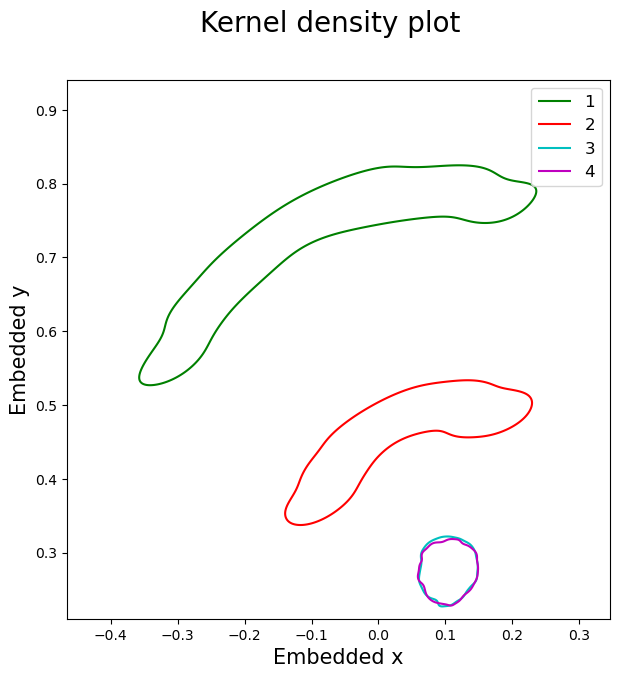

In [44]:
labels = ['1','2','3','4']

colors = ['g', 'r','c','m']

fig, ax = plt.subplots(1,1, figsize = (7,7))
fig.suptitle('Kernel density plot', fontsize = 20)
ax.set_xlabel('Embedded x', fontsize = 15)
ax.set_ylabel('Embedded y', fontsize = 15)

lab, h = [], []

for k in [1,2,3,4]:
    ind = torch.count_nonzero(targets_test == k)
    X = torch.zeros(1,1).expand(ind, 2).clone()

    l=0
    for i in torch.nonzero(targets_test == k)[:,0]:
        X[l] = sample_emb_test[0][i]
        l = l+1


    # Extract x and y
    x = X[:, 0]
    y = X[:, 1]

    # Define the borders
    deltaX = (torch.max(x) - torch.min(x))/5
    deltaY = (torch.max(y) - torch.min(y))/5
    xmin = torch.min(x).item() - deltaX.item()
    xmax = torch.max(x).item() + deltaX.item()
    ymin = torch.min(y).item() - deltaY.item()
    ymax = torch.max(y).item() + deltaX.item()

    # Create meshgrid
    xx, yy = np.mgrid[xmin:xmax:1000j, ymin:ymax:1000j]

    x = x.detach().numpy()
    y = y.detach().numpy()

    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])

    kernel = st.gaussian_kde(values)
    # kernel.set_bandwidth(bw_method=0.8)

    f = np.reshape(kernel(positions).T, xx.shape)


    #ax1_test = plt.gca()
    #print(colors[k])
    cset = ax.contour(xx, yy, f, levels = [10], colors = colors[k-1])

    h1, l1 = cset.legend_elements()
    h.append(h1[0])
    lab.append(labels[k-1])

ax.legend(h, lab, loc = 'best', fontsize = 12)
fig.savefig('/home/gbortolai/Thesis/Plot/Jets/Simple/KDE_1234_myloss_Transformer.pdf', facecolor='w',pad_inches=0.3, transparent=True)
lab, h = [], []

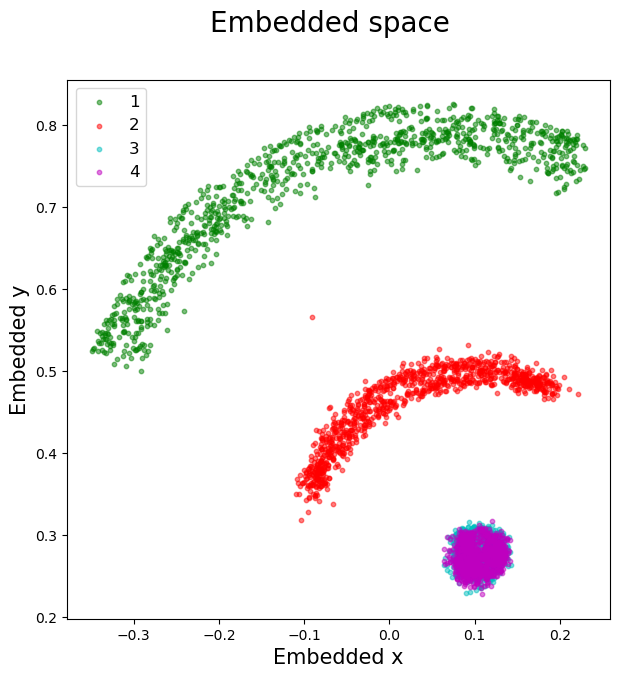

In [43]:
labels = ['1','2','3','4']

colors = ['g', 'r','c','m']

var, col = [], []

fig, ax = plt.subplots(1,1, figsize = (7,7))
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize = (10,10))

fig.suptitle('Embedded space', fontsize = 20)
ax.set_xlabel('Embedded x', fontsize = 15)
ax.set_ylabel('Embedded y', fontsize = 15)

for j in [1,2,3,4]:
    for i in torch.nonzero(targets_test == j)[:,0]:
        ax.scatter(sample_emb_test[0][i][0].cpu().detach().numpy(), sample_emb_test[0][i][1].cpu().detach().numpy(), color = colors[j-1], s=10, alpha = 0.5)
        # ax.scatter(sample_emb_test[0][i][0].cpu().detach().numpy(), sample_emb_test[0][i][1].cpu().detach().numpy(), sample_emb_test[0][i][2].cpu().detach().numpy(), color = colors[j], s=10, alpha = 0.5)
    var.append(labels[j-1])
    col.append(colors[j-1])
    
ax.legend(var,loc = 'best', fontsize = 12)

leg = ax.get_legend()    
for i in range(len(var)):

    leg.legend_handles[i].set_color(col[i])
    
fig.savefig('/home/gbortolai/Thesis/Plot/Jets/Simple/Embedded_1234_myloss_transformer.pdf', facecolor='w',pad_inches=0.3, transparent=True)
var, col = [], []